# Credit Risk Scoring

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
%matplotlib inline

### Data Preparation

In [2]:
# Load dataset and lowercase column names
df = pd.read_csv('data.csv')
df.columns = df.columns.str.lower()
df

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,2,1,1,60,39,2,1,1,69,92,0,0,900,1020
4451,1,22,2,60,46,2,1,1,60,75,3000,600,950,1263
4452,2,0,2,24,37,2,1,2,60,90,3500,0,500,963
4453,1,0,1,48,23,1,1,3,49,140,0,0,550,550


Convert categorical values to meaningful labels.

In [3]:
# Map variables
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}
df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)

df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [4]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [5]:
# Replace placeholder values (99999999) with NaN
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [6]:
# Remove rows with unknown status and reset index
df = df[df.status != 'unk']    
df = df.reset_index(drop=True)
print(df.status.value_counts())

status
ok         3200
default    1254
Name: count, dtype: int64


In [ ]:
# Check missing values
df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

In [10]:
# Drop rows with missing values
df = df.dropna()

# Verify
print("Missing values after dropna:")
print(df.isnull().sum())

Missing values after dropna:
status       0
seniority    0
home         0
time         0
age          0
marital      0
records      0
job          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
dtype: int64


### EDA

In [19]:
numerical_cols = ['seniority', 'time', 'age',
                   'expenses', 'income', 'assets',
                     'debt', 'amount', 'price']
categorical_cols = ['home', 'marital', 'records', 'job']

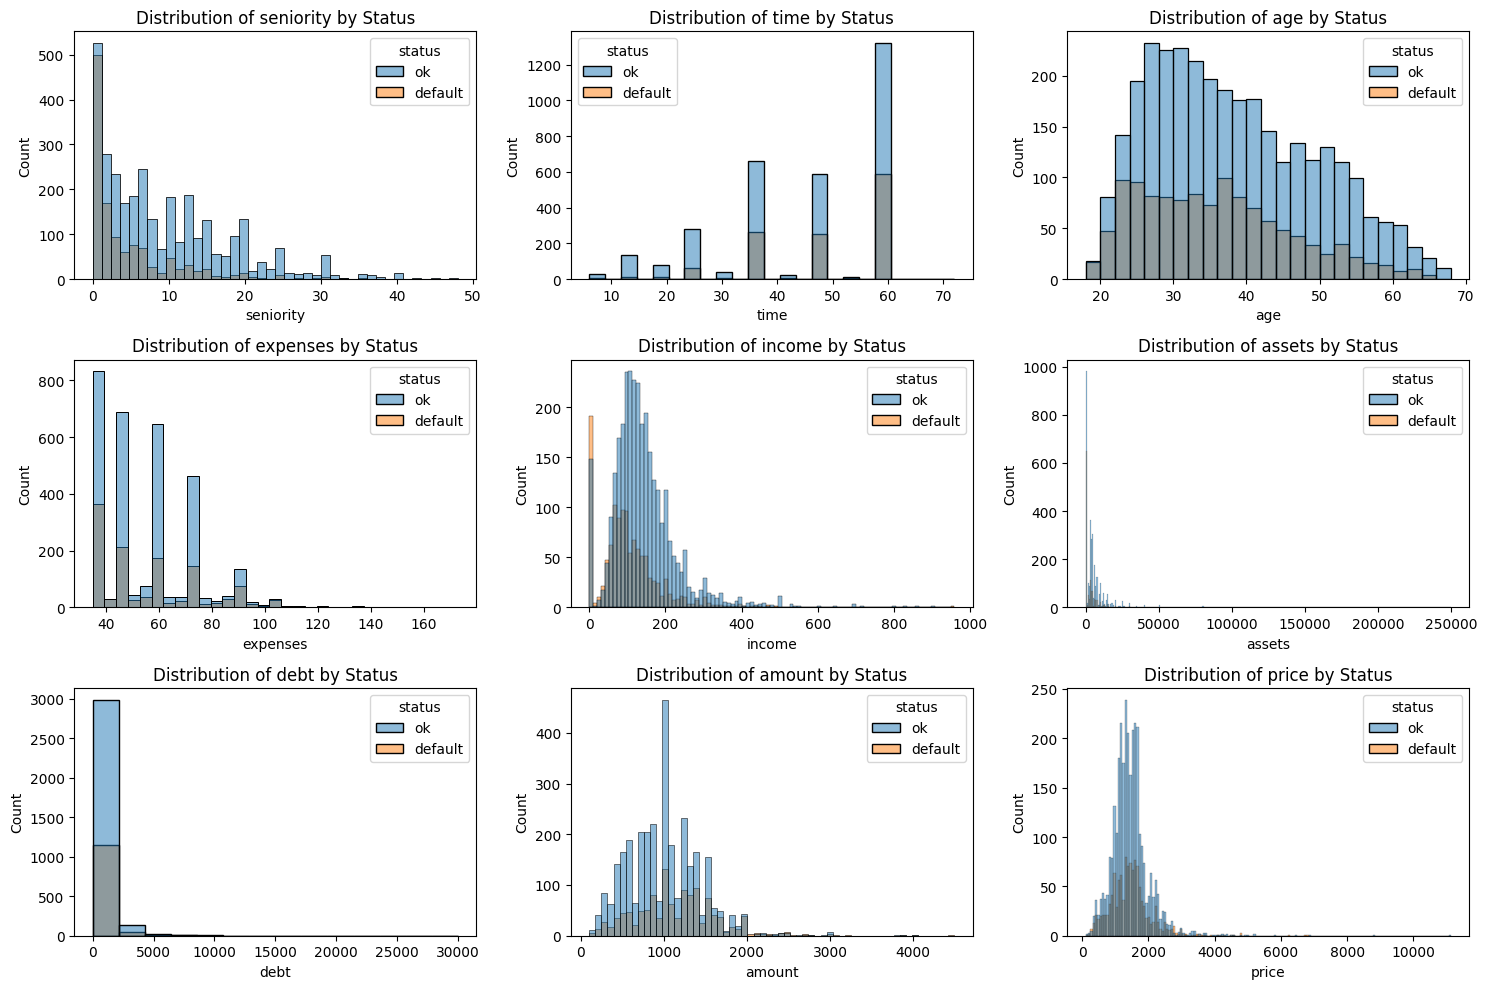

In [20]:
# Distribution plots for numerical variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, hue='status')
    plt.title(f'Distribution of {col} by Status')
plt.tight_layout()
plt.show()

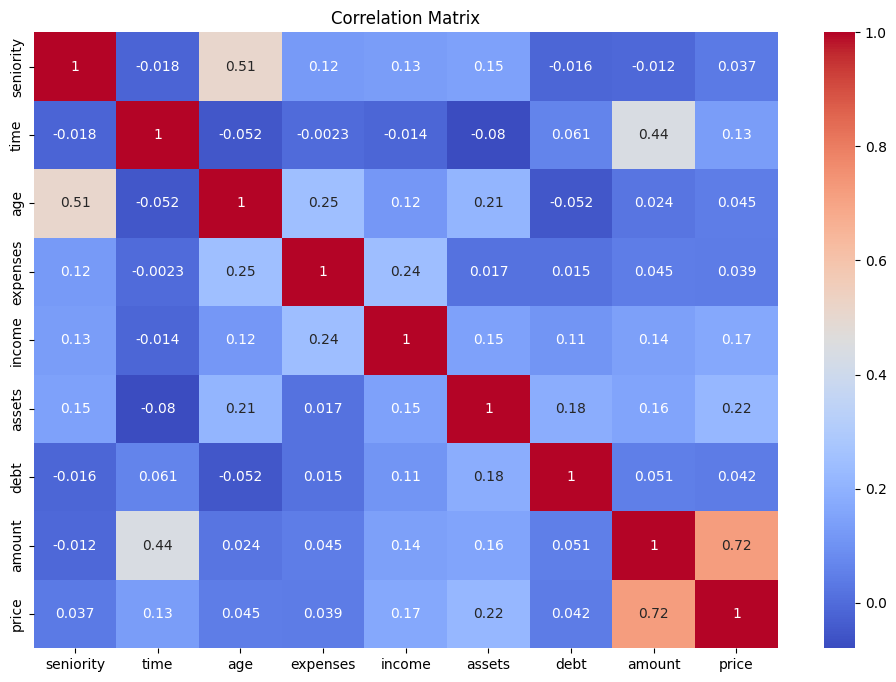

In [21]:
# Correlation analysis
plt.figure(figsize=(12, 8))
correlation = df[numerical_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

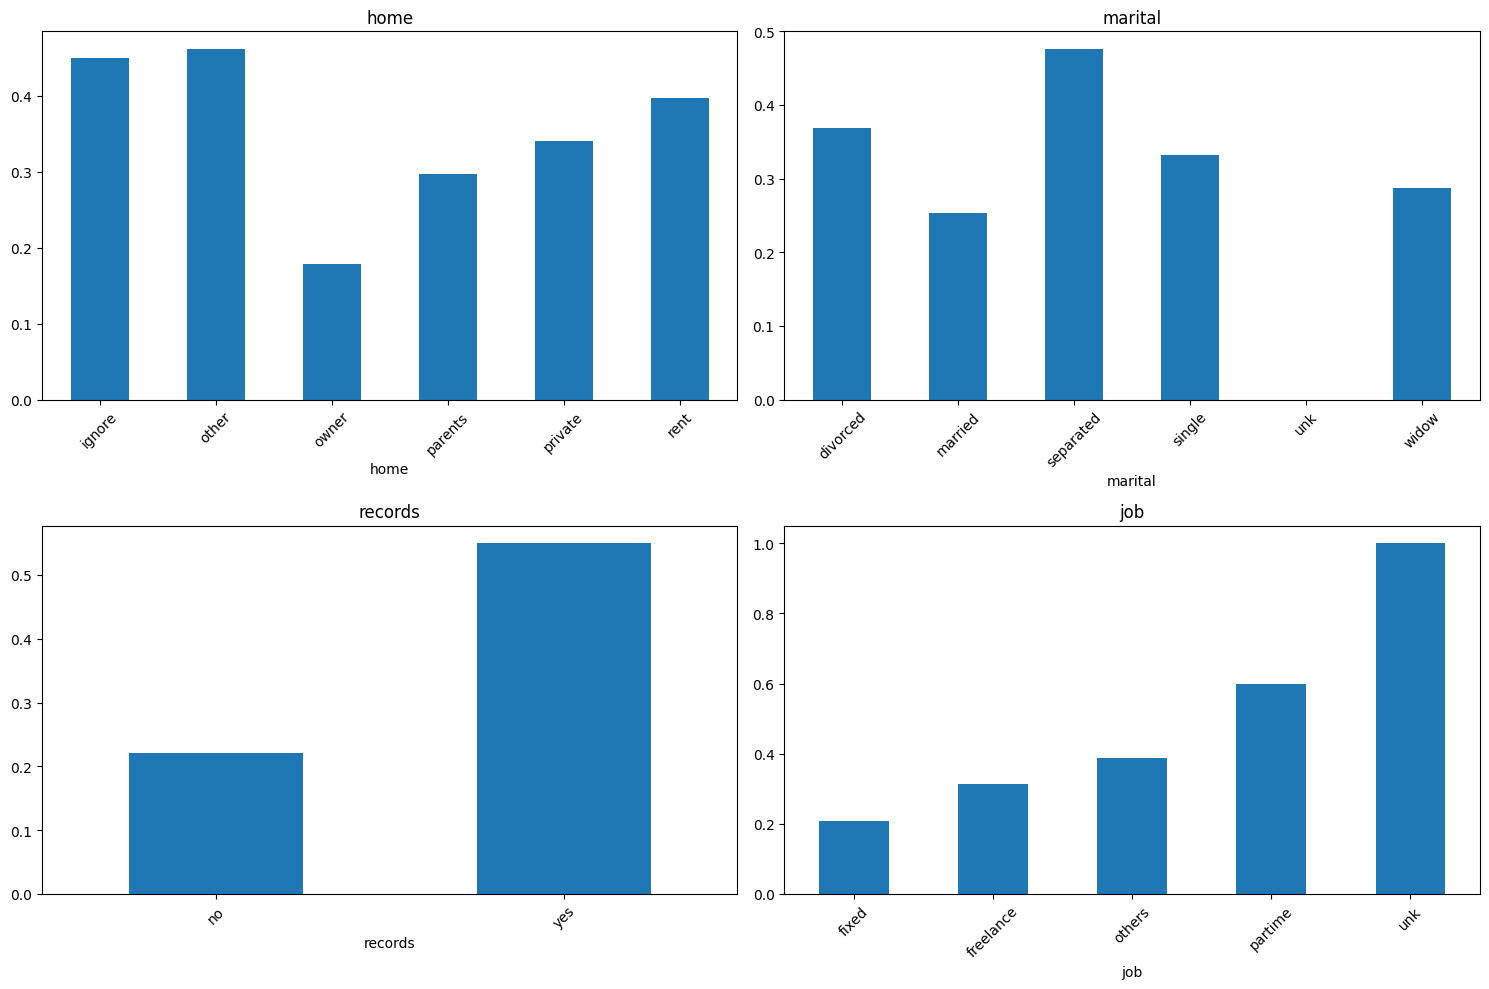

In [23]:
# Categorical variable analysis
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    default_rate = df.groupby(col)['status'].apply(lambda x: (x == 'default').mean())
    default_rate.plot(kind='bar')
    plt.title(f'{col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Train/Validation/Test Split

60 / 20 / 20

In [25]:
# Separate test set (20%)
df_full_train, df_test = train_test_split(
    df,
    test_size=0.2,       
    random_state=11   
)

In [26]:
# Separate validation set (25%)
df_train, df_val = train_test_split(
    df_full_train,      
    test_size=0.25,     
    random_state=11      
)

In [28]:
# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Convert 'default' to 1 and 'ok' to 0
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

# Remove target variable
del df_train['status']
del df_val['status']
del df_test['status']

In [33]:
print("Training:  ", df_train.shape)
print("Validation:", df_val.shape)
print("Test:      ", df_test.shape)

Training:   (2625, 13)
Validation: (876, 13)
Test:       (876, 13)


### Model Development

#### 1. Decision Tree (Basic model)

In [37]:
# Convert df to list of dictionaries and fill NaN with 0
train_dicts = df_train.fillna(0).to_dict(orient='records')

# Use DictVectorizer to convert categorical variables
dv = DictVectorizer(sparse=False)

# Learn the encoding and transform the data
X_train = dv.fit_transform(train_dicts)

# Create Decision Tree
dt = DecisionTreeClassifier()  # Using default parameters
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [38]:
# Evaluating on Training set
y_pred = dt.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
train_auc

1.0

In [39]:
# Evaluating on Validation set
val_dicts = df_val.fillna(0).to_dict(orient='records')  
X_val = dv.transform(val_dicts)                        
y_pred = dt.predict_proba(X_val)[:, 1]   
val_auc = roc_auc_score(y_val, y_pred)  
val_auc

0.6659010190194843

These results clearly show that our Decision Tree is overfitting:

- Train ROC AUC:        1.0     (100%)
- Validation ROC AUC:   0.665   (66.5%)

##### Conclusion:
- Training score of 1.0 means the model perfectly memorized the training data
- Validation score of 0.655 shows much worse performance on unseen data
- The large gap between train (1.0) and validation (0.665) scores is a classic sign of overfitting

#### 2. Decision Tree (Tuned Parameters)

Tuning hyperparameters for the Decision Tree to find the optimal configuration.
- max_depth
- min_samples_leaf

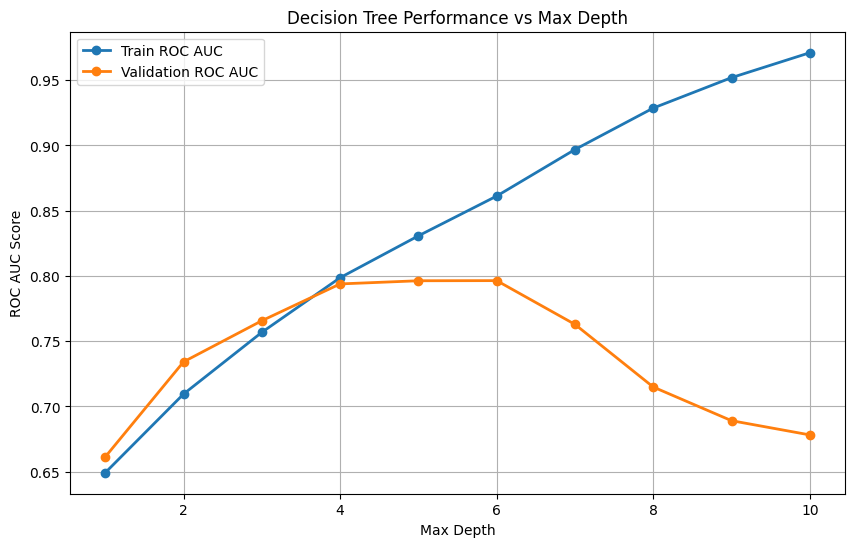

Best max_depth: 6


In [55]:
# Test different max_depths
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
scores = []

for d in depths:
    # Train model with specific depth
    dt = DecisionTreeClassifier(max_depth=d, random_state=1)
    dt.fit(X_train, y_train)
    
    # Get predictions
    train_pred = dt.predict_proba(X_train)[:, 1]
    val_pred = dt.predict_proba(X_val)[:, 1]
    
    # Calculate scores
    train_auc = roc_auc_score(y_train, train_pred)
    val_auc = roc_auc_score(y_val, val_pred)
    
    scores.append((d, train_auc, val_auc))

# Plot the results to visualize optimal depth
plt.figure(figsize=(10, 6))
depths = [s[0] for s in scores]
train_scores = [s[1] for s in scores]
val_scores = [s[2] for s in scores]

plt.plot(depths, train_scores, marker='o', label='Train ROC AUC', linewidth=2)
plt.plot(depths, val_scores, marker='o', label='Validation ROC AUC', linewidth=2)
plt.xlabel('Max Depth')
plt.ylabel('ROC AUC Score')
plt.title('Decision Tree Performance vs Max Depth')
plt.grid(True)
plt.legend()
plt.show()

# Find the depth with best validation score
best_depth = max(scores, key=lambda x: x[2])[0]
print(f'Best max_depth: {best_depth}')

In [ ]:
# Test different min_samples_leaf 
best_depths = [best_depth-1, best_depth, best_depth+1]  
min_samples = [1, 5, 10, 15, 20, 50, 100, 200]

for depth in best_depths:
    for s in min_samples:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=1)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

# Create pivot table of results
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])

print("Fine-tuned results:")
print(df_scores_pivot.round(3))

# Find best combination
best_score = df_scores.loc[df_scores['auc'].idxmax()]
print("\nBest parameters after fine-tuning:")
print(f"max_depth: {best_score['max_depth']}")
print(f"min_samples_leaf: {best_score['min_samples_leaf']}")
print(f"Best validation AUC: {best_score['auc']:.3f}")


Fine-tuned results:
                    auc              
max_depth             5      6      7
min_samples_leaf                     
1                 0.796  0.796  0.763
5                 0.795  0.793  0.784
10                0.785  0.788  0.795
15                0.785  0.790  0.807
20                0.803  0.804  0.802
50                0.801  0.803  0.804
100               0.814  0.816  0.814
200               0.781  0.783  0.783

Best parameters after fine-tuning:
max_depth: 6.0
min_samples_leaf: 100.0
Best validation AUC: 0.816


We've found that a max_depth of 6 and min_samples_leaf equal to 100 gives us the best performance with a validation ROC AUC of 0.816
- Higher min_samples_leaf (100) suggests the model benefits from larger, more stable leaf nodes.
- Moderate max_depth (6) provides good balance between complexity and generalization

In [ ]:
# Create final model with optimal hyperparameters
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=100, random_state=1)
dt.fit(X_train, y_train)

# Evaluate on all sets
train_pred = dt.predict_proba(X_train)[:, 1]
val_pred = dt.predict_proba(X_val)[:, 1]

# Prepare test set
test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)
test_pred = dt.predict_proba(X_test)[:, 1]

print('Final Model Performance (ROC AUC):')
print(f'Train:      {roc_auc_score(y_train, train_pred):.3f}')
print(f'Validation: {roc_auc_score(y_val, val_pred):.3f}')
print(f'Test:       {roc_auc_score(y_test, test_pred):.3f}')

Final Model Performance (ROC AUC):
Train:      0.811
Validation: 0.816
Test:       0.776


In [58]:
# Representation of the decision tree
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- seniority <= 2.50
|   |--- records=yes <= 0.50
|   |   |--- job=partime <= 0.50
|   |   |   |--- income <= 101.50
|   |   |   |   |--- income <= 59.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  59.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- income >  101.50
|   |   |   |   |--- price <= 1348.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1348.50
|   |   |   |   |   |--- class: 0
|   |   |--- job=partime >  0.50
|   |   |   |--- class: 1
|   |--- records=yes >  0.50
|   |   |--- class: 1
|--- seniority >  2.50
|   |--- records=no <= 0.50
|   |   |--- income <= 109.50
|   |   |   |--- class: 1
|   |   |--- income >  109.50
|   |   |   |--- class: 0
|   |--- records=no >  0.50
|   |   |--- income <= 73.50
|   |   |   |--- assets <= 3550.00
|   |   |   |   |--- class: 0
|   |   |   |--- assets >  3550.00
|   |   |   |   |--- class: 0
|   |   |--- income >  73.50
|   |   |   |--- assets <= 1650.00
|   |   |   |   |--- amount <= 1020.0

#### 3. Random Forest (Tuned Parameters)

In [77]:
scores = []

# Test combinations of max_depth and n_estimators
for d in range(1, 20, 1):                   
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(
            n_estimators=n,        
            max_depth=d,          
            random_state=1
        )
        rf.fit(X_train, y_train)

        # Get predictions and calculate AUC
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, n, auc))

# Convert results to DataFrame
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)


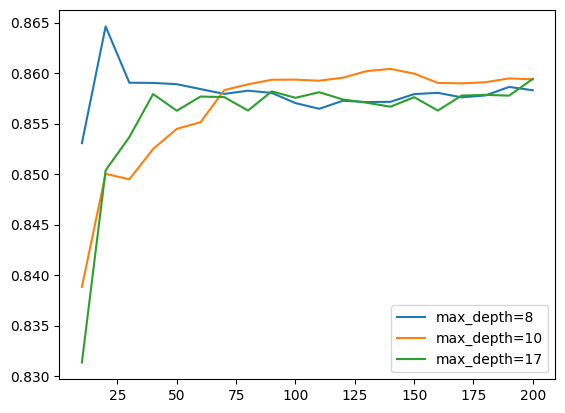

In [78]:
# Plot
for d in [8,10,17]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(
        df_subset.n_estimators,      
        df_subset.auc,                  
        label='max_depth=%d' % d         
    )
plt.legend()

In [92]:
max_depth = 10    
scores = []

# Test combinations of min_samples_leaf and n_estimators
for s in [1, 3, 5, 10, 15, 20, 50]:  
    for n in range(10, 201, 10):     
        rf = RandomForestClassifier(
            n_estimators=n,              
            max_depth=max_depth,         
            min_samples_leaf=s,          
            random_state=1
        )
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((s, n, auc))

columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

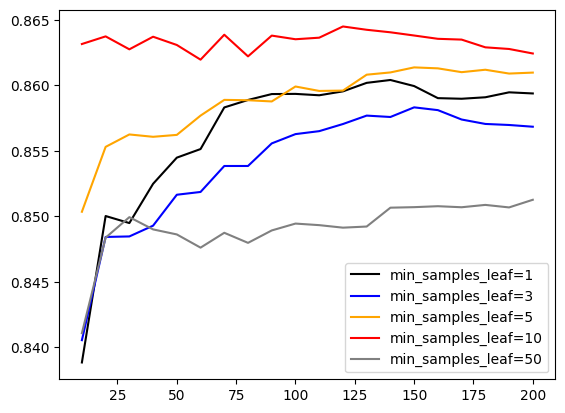

In [93]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

# Plot
for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)
plt.legend()

In [94]:
# Best Random Forest
rf = RandomForestClassifier(
    n_estimators=200,         
    max_depth=3,             
    min_samples_leaf=10,      
    random_state=1            
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=10, n_estimators=200,
                       random_state=1)

In [97]:
# Get predictions
train_pred = rf.predict_proba(X_train)[:, 1]
val_pred = rf.predict_proba(X_val)[:, 1]

test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)
test_pred = rf.predict_proba(X_test)[:, 1]

print('Random Forest Performance (ROC AUC):')
print(f'Train:      {roc_auc_score(y_train, train_pred):.3f}')
print(f'Validation: {roc_auc_score(y_val, val_pred):.3f}')
print(f'Test:       {roc_auc_score(y_test, test_pred):.3f}')

Random Forest Performance (ROC AUC):
Train:      0.829
Validation: 0.841
Test:       0.820


- Random Forest (RF) performs better than the single Decision Tree
- Parameters chosen (n_estimators=200, max_depth=3, min_samples_leaf=10) provide good balance

#### 4. XGBoost (Tuned Parameters)

In [99]:
# Get feature names from our DictVectorizer
features = list(dv.get_feature_names_out())

dtrain = xgb.DMatrix(
    X_train,               
    label=y_train,         
    feature_names=features  
)

dval = xgb.DMatrix(
    X_val,               
    label=y_val,           
    feature_names=features  
)

In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8486075613237295

In [ ]:
# Tuning hyperparameters
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

# Grid search
scores = []
watchlist = [(dtrain, 'train'), (dval, 'val')]

# Iterate through each parameter combination
for eta in param_grid['eta']:
    for max_depth in param_grid['max_depth']:
        for min_child_weight in param_grid['min_child_weight']:
            for subsample in param_grid['subsample']:
                for colsample_bytree in param_grid['colsample_bytree']:
                    params = {
                        'eta': eta,
                        'max_depth': max_depth,
                        'min_child_weight': min_child_weight,
                        'subsample': subsample,
                        'colsample_bytree': colsample_bytree
                    }
                    current_params = {**base_params, **params}
                    
                    model = xgb.train(
                        current_params,
                        dtrain,
                        num_boost_round=100,
                        evals=watchlist,
                        verbose_eval=False
                    )
                    
                    # Get validation score
                    y_pred = model.predict(dval)
                    auc = roc_auc_score(y_val, y_pred)
                    
                    # Store results
                    scores.append((params, auc))

# Find best parameters
best_score = max(scores, key=lambda x: x[1])
print("\nBest parameters:")
print(f"Params: {best_score[0]}")
print(f"AUC: {best_score[1]:.4f}")

Params: {'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}
AUC: 0.8465

Params: {'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.9}
AUC: 0.8460

Params: {'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 1.0}
AUC: 0.8457

Params: {'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.8}
AUC: 0.8447

Params: {'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9}
AUC: 0.8429

Params: {'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 1.0}
AUC: 0.8440

Params: {'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.8}
AUC: 0.8414

Params: {'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.9}
AUC: 0.8413

Params: {'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'su

In [106]:
# Best parameters from grid search
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Train final model
final_model = xgb.train(
    xgb_params, 
    dtrain,
    num_boost_round=200,
    evals=watchlist,
    verbose_eval=10
)

y_pred_train = final_model.predict(dtrain)
y_pred_val = final_model.predict(dval)

# Prepare test data and predict
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)
y_pred_test = final_model.predict(dtest)

# Print final scores
print('\nFinal Model Performance (ROC AUC):')
print(f'Train:      {roc_auc_score(y_train, y_pred_train):.3f}')
print(f'Validation: {roc_auc_score(y_val, y_pred_val):.3f}')
print(f'Test:       {roc_auc_score(y_test, y_pred_test):.3f}')

[0]	train-auc:0.75729	val-auc:0.78016


[10]	train-auc:0.83807	val-auc:0.84359
[20]	train-auc:0.85701	val-auc:0.85406
[30]	train-auc:0.86765	val-auc:0.85807
[40]	train-auc:0.87657	val-auc:0.86108
[50]	train-auc:0.88160	val-auc:0.86505
[60]	train-auc:0.88510	val-auc:0.86727
[70]	train-auc:0.89032	val-auc:0.86911
[80]	train-auc:0.89486	val-auc:0.87073
[90]	train-auc:0.89789	val-auc:0.87130
[100]	train-auc:0.90122	val-auc:0.86970
[110]	train-auc:0.90438	val-auc:0.87068
[120]	train-auc:0.90802	val-auc:0.86984
[130]	train-auc:0.91015	val-auc:0.87070
[140]	train-auc:0.91262	val-auc:0.86971
[150]	train-auc:0.91498	val-auc:0.86913
[160]	train-auc:0.91753	val-auc:0.86732
[170]	train-auc:0.91989	val-auc:0.86723
[180]	train-auc:0.92230	val-auc:0.86609
[190]	train-auc:0.92445	val-auc:0.86459
[199]	train-auc:0.92582	val-auc:0.86370

Final Model Performance (ROC AUC):
Train:      0.926
Validation: 0.864
Test:       0.839


### Model Comparison and Selection

1. **Decision Tree (Default Parameters)**  
   - Validation ROC AUC: **0.665**  

2. **Decision Tree (Tuned Parameters)**  
   - Best parameters: `max_depth=6`, `min_samples_leaf=100`  
   - Best Validation ROC AUC: **0.816**  

3. **Random Forest (Tuned Parameters)**  
   - Best parameters: `n_estimators=200`, `max_depth=3`, `min_samples_leaf=10`  
   - ROC AUC Scores:  
     - Train: **0.829**  
     - Validation: **0.841**  
     - Test: **0.820**   

4. **XGBoost (Tuned Parameters)**  
   - Best parameters: `eta=0.1`, `max_depth=3`, `min_child_weight=5`, `subsample=0.8`, `colsample_bytree=1.0`  
   - ROC AUC Scores:  
     - Train: **0.926**  
     - Validation: **0.864**  
     - Test: **0.839**  

#### Conclusion:
- **Tuned XGBoost** achieved the best results with the highest Validation ROC AUC (0.864) and strong performance on the test set (0.839).  


<hr>

### Feature Engineering

In [ ]:
def create_features(df):
    df = df.copy()
    
    # Financial Ratios (Numeric features)
    df['debt_to_income'] = df['debt'] / df['income']
    df['loan_to_income'] = df['amount'] / df['income']
    df['expense_ratio'] = df['expenses'] / df['income']
    df['asset_to_debt'] = df['assets'] / df['debt']
    df['payment_to_income'] = (df['amount'] / df['time']) / df['income']
    
    # Age-based Features
    df['age_squared'] = df['age'] ** 2
    
    # Create age_group as string instead of categorical
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 25, 35, 45, 55, 100],
                            labels=['Young', 'Young_Adult', 'Adult', 'Senior', 'Elder']).astype(str)
    
    # Interaction Features
    df['income_per_age'] = df['income'] / df['age']
    df['debt_per_age'] = df['debt'] / df['age']
    df['assets_per_age'] = df['assets'] / df['age']
    
    # Flag Features
    df['high_debt_flag'] = (df['debt_to_income'] > df['debt_to_income'].median()).astype(int)
    df['low_income_flag'] = (df['income'] < df['income'].median()).astype(int)
    df['high_loan_request_flag'] = (df['amount'] > df['amount'].median()).astype(int)
    
    # Handle infinite values
    df = df.replace([np.inf, -np.inf], np.nan)
    
    return df

df_engineered = create_features(df)

In [112]:
# Split the data again
df_full_train, df_test = train_test_split(df_engineered, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

# Prepare features and target
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

del df_train['status']
del df_val['status']
del df_test['status']

# Handle missing values appropriately
train_dicts = df_train.fillna(-999).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.fillna(-999).to_dict(orient='records')
X_val = dv.transform(val_dicts)

# XGBoost
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

# 5. Train XGBoost with best parameters from before
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, 'train'), (dval, 'val')],
    verbose_eval=10
)

y_pred = model.predict(dval)
print(f'\nValidation AUC: {roc_auc_score(y_val, y_pred):.3f}')

[0]	train-auc:0.75689	val-auc:0.77739
[10]	train-auc:0.84468	val-auc:0.84368
[20]	train-auc:0.86293	val-auc:0.85511
[30]	train-auc:0.87231	val-auc:0.85705
[40]	train-auc:0.88209	val-auc:0.85969
[50]	train-auc:0.88888	val-auc:0.86173
[60]	train-auc:0.89294	val-auc:0.86402
[70]	train-auc:0.89862	val-auc:0.86544
[80]	train-auc:0.90407	val-auc:0.86689
[90]	train-auc:0.90757	val-auc:0.86448
[100]	train-auc:0.91098	val-auc:0.86478
[110]	train-auc:0.91398	val-auc:0.86454
[120]	train-auc:0.91747	val-auc:0.86284
[130]	train-auc:0.92026	val-auc:0.86271
[140]	train-auc:0.92320	val-auc:0.86322
[150]	train-auc:0.92672	val-auc:0.86271
[160]	train-auc:0.92913	val-auc:0.86226
[170]	train-auc:0.93138	val-auc:0.86175
[180]	train-auc:0.93388	val-auc:0.86094
[190]	train-auc:0.93622	val-auc:0.86116
[199]	train-auc:0.93766	val-auc:0.86113

Validation AUC: 0.861


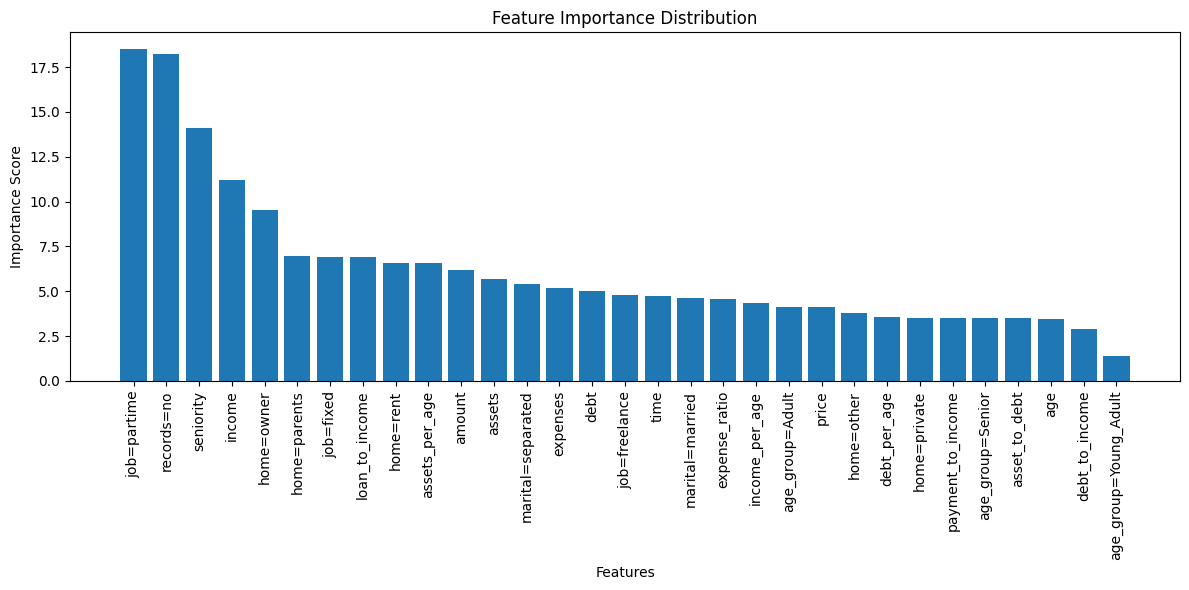


Number of features to explain:
50.0% of importance explained by top 9 features
70.0% of importance explained by top 16 features
80.0% of importance explained by top 20 features
90.0% of importance explained by top 25 features


In [116]:
# Get importance scores for all features
importance = model.get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Plot feature importances
plt.figure(figsize=(12, 6))
features, scores = zip(*sorted_importance)
plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation=90)
plt.title('Feature Importance Distribution')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

# Calculate cumulative importance
cumulative_importance = np.cumsum(scores) / np.sum(scores)
print("\nNumber of features to explain:")
for threshold in [0.5, 0.7, 0.8, 0.9]:
    n_features = sum(cumulative_importance <= threshold) + 1
    print(f"{threshold*100}% of importance explained by top {n_features} features")

In [117]:
print("Top 16 Features:")
for feature, importance in sorted_importance[:16]:
    print(f"{feature}: {importance:.2f}")

Top 16 Features:
job=partime: 18.52
records=no: 18.26
seniority: 14.12
income: 11.21
home=owner: 9.56
home=parents: 6.97
job=fixed: 6.94
loan_to_income: 6.92
home=rent: 6.58
assets_per_age: 6.55
amount: 6.21
assets: 5.67
marital=separated: 5.41
expenses: 5.21
debt: 5.04
job=freelance: 4.79


Self-learning credit scoring system

In [147]:
class DynamicCreditScoring:
    def __init__(self, initial_weights=None):
        # Initialize with original XGBoost importance as base weights
        self.base_weights = {
            'job_partime': 18.52,
            'records_no': 18.26,
            'seniority': 14.12,
            'income': 11.21,
            'home_owner': 9.56,
            'home_parents': 6.97,
            'job_fixed': 6.94,
            'loan_to_income': 6.92,
            'home_rent': 6.58,
            'assets_per_age': 6.55,
            'amount': 6.21,
            'assets': 5.67,
            'marital_separated': 5.41,
            'expenses': 5.21,
            'debt': 5.04,
            'job_freelance': 4.79
        }
        self.weights = self.base_weights.copy()
        self.performance_history = []
        self.learning_rate = 0.01
        self.adaptation_factor = 0.1

    def calculate_score(self, client_data):
        """
        Enhanced credit scoring method with comprehensive risk assessment
        
        Args:
            client_data (dict): Client's financial and personal information
        
        Returns:
            tuple: (final score, score components, current weights)
        """
        import math

        # Base score starts at neutral 50
        base_score = 50
        score_components = {}
        
        # 1. Employment Stability Scoring
        def calculate_employment_score(job, seniority):
            # Job type base scores
            job_scores = {
                'fixed': 30,      # Most stable
                'partime': 15,    # Moderate stability
                'freelance': 10   # Least stable
            }
            
            # Base employment score
            emp_score = job_scores.get(job, 0)
            
            # Seniority multiplier (logarithmic growth)
            seniority_multiplier = min(1 + (math.log(seniority + 1) / 3), 2)
            emp_score *= seniority_multiplier
            
            return max(0, emp_score)
        
        # 2. Financial Health Scoring
        def calculate_financial_score(income, debt, expenses, loan_to_income, assets):
            financial_score = 0
            
            # Income Quality Assessment
            income_quality = min(income / 50000, 1) * 20  # Normalized to 50k
            financial_score += income_quality
            
            # Debt-to-Income Ratio Analysis
            debt_to_income = debt / max(income, 1)
            if debt_to_income < 0.2:
                financial_score += 15
            elif debt_to_income < 0.4:
                financial_score += 10
            elif debt_to_income < 0.6:
                financial_score += 5
            else:
                financial_score -= 10  # Severe penalty
            
            # Loan to Income Ratio Penalty
            lti_penalty = max(0, (loan_to_income - 0.3) * 50)  # Incremental penalty
            financial_score -= lti_penalty
            
            # Asset Buffer Assessment
            annual_expenses = expenses * 12
            asset_buffer_ratio = assets / max(annual_expenses, 1)
            if asset_buffer_ratio > 6:  # 6 months of expenses
                financial_score += 10
            elif asset_buffer_ratio > 3:
                financial_score += 5
            
            return max(min(financial_score, 30), -20)
        
        # 3. Credit History Evaluation
        def calculate_credit_score(records, marital_status):
            # Base credit score
            base_credit_score = 25 if records == 'no' else -25
            
            # Marital status adjustments
            marital_adjustments = {
                'married': 5,     # Stability bonus
                'single': 0,
                'separated': -5   # Potential financial stress
            }
            
            return base_credit_score + marital_adjustments.get(marital_status, 0)
        
        # 4. Housing and Stability Scoring
        def calculate_housing_score(home_type, assets_per_age):
            # Housing type base scores
            housing_scores = {
                'owner': 15,      # Most stable
                'parents': 6,     # Supported living
                'rent': 2         # Less stable
            }
            
            # Base housing score
            housing_score = housing_scores.get(home_type, 0)
            
            # Assets per age consideration
            age_asset_ratio = min(assets_per_age / 50000, 1) * 5
            housing_score += age_asset_ratio
            
            return housing_score
        
        # Calculate individual component scores
        employment_score = calculate_employment_score(
            client_data['job'], 
            client_data['seniority']
        )
        financial_score = calculate_financial_score(
            client_data['income'], 
            client_data['debt'], 
            client_data['expenses'], 
            client_data['loan_to_income'],
            client_data['assets']
        )
        credit_score = calculate_credit_score(
            client_data['records'], 
            client_data['marital']
        )
        housing_score = calculate_housing_score(
            client_data['home'], 
            client_data['assets_per_age']
        )
        
        # Store component scores
        score_components = {
            'employment_score': employment_score,
            'financial_score': financial_score,
            'credit_score': credit_score,
            'housing_score': housing_score
        }
        
        # Final score calculation with weighted components
        final_score = (
            base_score +
            employment_score * 0.25 +
            financial_score * 0.3 +
            credit_score * 0.25 +
            housing_score * 0.2
        )
        
        # Ensure score is between 0 and 100
        final_score = max(0, min(100, final_score))
        
        return final_score, score_components, self.weights

    def update_weights(self, prediction, actual_outcome, applied_weights):
        """Enhanced weight updating with constraints"""
        error = actual_outcome - prediction
        
        # Maximum allowed weight change per update
        max_adjustment = 0.1
        
        # Minimum and maximum allowed weights
        min_weight = -0.5
        max_weight = 2.0
        
        for feature, contribution in applied_weights.items():
            # Calculate proposed adjustment
            adjustment = self.learning_rate * error * contribution
            
            # Limit the size of adjustment
            adjustment = max(min(-max_adjustment, adjustment), 
                            min(max_adjustment, adjustment))
            
            # Update weight with constraints
            current_weight = self.weights[feature]
            new_weight = current_weight + adjustment
            
            # Ensure weight stays within reasonable bounds
            self.weights[feature] = max(min_weight, 
                                    min(max_weight, new_weight))
        
        # Track performance
        self.performance_history.append({
            'error': error,
            'weights': self.weights.copy()
        })
        
        # Normalize weights
        self._normalize_weights()

    def _get_feature_value(self, client_data, feature):
        """Extract normalized feature value from client data"""
        if feature == 'loan_to_income':
            return 1 if client_data['loan_to_income'] < 0.3 else -1
        elif feature.startswith('job_'):
            job_type = feature.split('_')[1]
            return 1 if client_data['job'] == job_type else 0
        elif feature.startswith('home_'):
            home_type = feature.split('_')[1]
            return 1 if client_data['home'] == home_type else 0
        elif feature in client_data:
            # Normalize numerical values
            return self._normalize_value(client_data[feature], feature)
        return 0

    def _normalize_value(self, value, feature):
        """Normalize numerical values to [-1, 1] range"""
        # Feature-specific normalization logic
        if feature == 'income':
            return min(value / 100000, 1)  # Normalize relative to 100k
        elif feature == 'debt':
            return -min(value / 50000, 1)  # Negative impact, normalize relative to 50k
        return value

    def _normalize_score(self, score):
        """Ensure final score is between 0 and 100"""
        return max(0, min(100, score))

    def _normalize_weights(self):
        """Improved weight normalization maintaining relative importance"""
        total_base_importance = sum(self.base_weights.values())
        
        # Calculate adjustment factor while preserving relative importance
        for feature in self.weights:
            base_proportion = self.base_weights[feature] / total_base_importance
            max_deviation = base_proportion * self.adaptation_factor
            
            # Limit weight changes based on original importance
            min_weight = base_proportion * (1 - max_deviation)
            max_weight = base_proportion * (1 + max_deviation)
            
            self.weights[feature] = max(min_weight, min(max_weight, self.weights[feature]))
        
        # Ensure weights sum to 100
        total = sum(self.weights.values())
        self.weights = {k: (v/total)*100 for k, v in self.weights.items()}

    def get_performance_metrics(self):
        """Return performance metrics of the scoring system"""
        if self.performance_history:
            recent_errors = [p['error'] for p in self.performance_history[-100:]]
            return {
                'average_error': sum(recent_errors) / len(recent_errors),
                'current_weights': self.weights
            }
        return None
    
# Initialize the dynamic scoring system
scoring_system = DynamicCreditScoring()

In [ ]:
# Case Scenarios and Sensitivity Analysis
extreme_cases = [
    # 1. High Income, Poor Credit
    {
        'job': 'fixed',
        'records': 'yes',
        'seniority': 10,
        'income': 150000,
        'home': 'owner',
        'loan_to_income': 0.50,
        'assets_per_age': 100000,
        'amount': 300000,
        'assets': 600000,
        'expenses': 6000,
        'debt': 120000,
        'marital': 'married'
    },
    
    # 2. Low Income, Perfect Credit
    {
        'job': 'partime',
        'records': 'no',
        'seniority': 3,
        'income': 30000,
        'home': 'rent',
        'loan_to_income': 0.20,
        'assets_per_age': 10000,
        'amount': 50000,
        'assets': 40000,
        'expenses': 2000,
        'debt': 6000,
        'marital': 'single'
    },
    
    # 3. Multiple Negative Factors
    {
        'job': 'freelance',
        'records': 'yes',
        'seniority': 1,
        'income': 40000,
        'home': 'parents',
        'loan_to_income': 0.70,
        'assets_per_age': 5000,
        'amount': 60000,
        'assets': 20000,
        'expenses': 2500,
        'debt': 50000,
        'marital': 'separated'
    },
    
    # 4. Multiple Positive Factors
    {
        'job': 'fixed',
        'records': 'no',
        'seniority': 15,
        'income': 120000,
        'home': 'owner',
        'loan_to_income': 0.15,
        'assets_per_age': 100000,
        'amount': 400000,
        'assets': 800000,
        'expenses': 5500,
        'debt': 40000,
        'marital': 'married'
    },
    
    # 5. Young Professional with Potential
    {
        'job': 'fixed',
        'records': 'no',
        'seniority': 2,
        'income': 65000,
        'home': 'rent',
        'loan_to_income': 0.35,
        'assets_per_age': 30000,
        'amount': 100000,
        'assets': 120000,
        'expenses': 2800,
        'debt': 20000,
        'marital': 'single'
    },
    
    # 6. Sensitive Employment Scenario
    {
        'job': 'freelance',
        'records': 'no',
        'seniority': 5,
        'income': 80000,
        'home': 'rent',
        'loan_to_income': 0.40,
        'assets_per_age': 50000,
        'amount': 150000,
        'assets': 250000,
        'expenses': 3500,
        'debt': 60000,
        'marital': 'single'
    },
    
    # 7. Borderline Medium-to-High Risk
    {
        'job': 'partime',
        'records': 'yes',
        'seniority': 3,
        'income': 55000,
        'home': 'rent',
        'loan_to_income': 0.45,
        'assets_per_age': 25000,
        'amount': 90000,
        'assets': 100000,
        'expenses': 2900,
        'debt': 35000,
        'marital': 'separated'
    },
    
    # 8. Asset-Rich but Income-Limited
    {
        'job': 'fixed',
        'records': 'no',
        'seniority': 8,
        'income': 70000,
        'home': 'owner',
        'loan_to_income': 0.25,
        'assets_per_age': 90000,
        'amount': 200000,
        'assets': 500000,
        'expenses': 4000,
        'debt': 30000,
        'marital': 'married'
    },
    
    # 9. High Debt, Strong Income
    {
        'job': 'fixed',
        'records': 'yes',
        'seniority': 12,
        'income': 110000,
        'home': 'owner',
        'loan_to_income': 0.50,
        'assets_per_age': 75000,
        'amount': 250000,
        'assets': 400000,
        'expenses': 5000,
        'debt': 130000,
        'marital': 'married'
    },
    
    # 10. Emerging Entrepreneurial Profile
    {
        'job': 'freelance',
        'records': 'no',
        'seniority': 4,
        'income': 65000,
        'home': 'rent',
        'loan_to_income': 0.30,
        'assets_per_age': 40000,
        'amount': 120000,
        'assets': 180000,
        'expenses': 3200,
        'debt': 35000,
        'marital': 'single'
    }
]

print("Credit Risk Assessment:\n")
for client in extreme_cases:
    # Calculate score
    score, components, weights = scoring_system.calculate_score(client)
    
    # Determine risk profile
    if score >= 75:
        risk_profile = "Low Risk"
    elif score >= 50:
        risk_profile = "Medium Risk"
    else:
        risk_profile = "High Risk"
    
    # Print detailed results
    print(f"Risk Profile: {risk_profile}")
    print(f"Total Score: {score:.2f}")
    print("Score Components:")
    for component, value in components.items():
        print(f"  - {component}: {value:.2f}")
    print("\n" + "="*50 + "\n")

Credit Risk Assessment:

Risk Profile: Medium Risk
Total Score: 65.49
Score Components:
  - employment_score: 53.98
  - financial_score: 10.00
  - credit_score: -20.00
  - housing_score: 20.00


Risk Profile: Medium Risk
Total Score: 68.93
Score Components:
  - employment_score: 21.93
  - financial_score: 22.00
  - credit_score: 25.00
  - housing_score: 3.00


Risk Profile: High Risk
Total Score: 42.68
Score Components:
  - employment_score: 12.31
  - financial_score: -14.00
  - credit_score: -30.00
  - housing_score: 6.50


Risk Profile: Low Risk
Total Score: 84.93
Score Components:
  - employment_score: 57.73
  - financial_score: 30.00
  - credit_score: 30.00
  - housing_score: 20.00


Risk Profile: Low Risk
Total Score: 76.50
Score Components:
  - employment_score: 40.99
  - financial_score: 30.00
  - credit_score: 25.00
  - housing_score: 5.00


Risk Profile: Medium Risk
Total Score: 64.64
Score Components:
  - employment_score: 15.97
  - financial_score: 10.00
  - credit_score: 25

##### Key Observations:

- Employment stability significantly impacts score
- Credit history is crucial
- Seniority provides substantial scoring advantages
- Housing ownership correlates with lower risk

#### Conclusion

The dynamic credit scoring model offers a highly sophisticated and holistic approach that is tailored to modern financial profiles. It provides a clear advantage over traditional scoring systems by incorporating diverse, real-world financial scenarios and adapting over time. The combination of non-linear scoring, dynamic weighting, and the inclusion of both traditional and non-traditional features (such as marital status and housing type) leads to a model that is not only comprehensive but also adaptive to future data trends.